## AlphaZero algorithm implementation and testing using an openAI gym enviroment.

In [1]:
'''
We will test our AlphaZero algorithm using an openAI gym environment named "CartPole".
You can read more information about the environment at this link:
https://www.gymlibrary.ml/environments/classic_control/cart_pole/

Feel free to change the environment with other as you like, changing the game name variable, 
but keep in mind that for this AlphaZero implementation both Actions and Observation must be Discrete. 
'''

# uncomment these lines below if you get a runtime error of gym package not found
# change the path value using your actual gym path using the 'pip show gym' command
#import sys
#path = "c:\\users\\my\\anaconda3\\envs\\mcts\\lib\\site-packages"
#sys.path.append(path)

import numpy
import gym

GAME_NAME = 'CartPole-v1'

env = gym.make(GAME_NAME)
    
GAME_ACTIONS = env.action_space.n
GAME_OBS = env.observation_space.shape[0]

print('In the ' + GAME_NAME + ' environment there are: ' + str(GAME_ACTIONS) + ' possible actions.')
print('In the ' + GAME_NAME + ' environment the observation is composed of: ' + str(GAME_OBS) + ' values.')

env.reset()
env.close()

In the CartPole-v1 environment there are: 2 possible actions.
In the CartPole-v1 environment the observation is composed of: 4 values.


In [2]:
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.set_floatx('float64')

HIDDEN_STATES = 64

'''
We will use 2 Neural Networks for the algorithm implementation.
Note that can be also implemented as one single network sharing the same weights that will produce two outputs.
Also, often there is the usage of a CNN (Convolutional Neural Network) architecture in order to deal with the dynamic pixels of the game directly.
'''

class PolicyV(keras.Model):
    
    '''
    The Value Neural Network will approximate the Value of the node, given a State of the game.
    '''
    
    def __init__(self):
        
        super(PolicyV, self).__init__()

        self.dense1 = keras.layers.Dense(HIDDEN_STATES, 
                                         activation='relu',
                                         kernel_initializer=keras.initializers.he_normal(),
                                         name='dense_1')

        self.dense2 = keras.layers.Dense(HIDDEN_STATES, 
                                         activation='relu',
                                         kernel_initializer=keras.initializers.he_normal(),
                                         name='dense_2')
        
        self.v_out = keras.layers.Dense(1,
                                        kernel_initializer=keras.initializers.he_normal(),
                                        name='v_out')
        
        
    def call(self, input):               
        
        x = self.dense1(input)
        x = self.dense2(x)       
        x = self.v_out(x)
        
        return x
    
    
    
class PolicyP(keras.Model):
    
    '''
    The Policy Neural Network will approximate the MCTS policy for the choice of nodes, given a State of the game.
    '''
    
    def __init__(self):
        
        super(PolicyP, self).__init__()

        self.dense1 = keras.layers.Dense(HIDDEN_STATES, 
                                         activation='relu',
                                         kernel_initializer=keras.initializers.he_normal(),
                                         name='dense_1')

        self.dense2 = keras.layers.Dense(HIDDEN_STATES, 
                                         activation='relu',
                                         kernel_initializer=keras.initializers.he_normal(),
                                         name='dense_2')

        self.p_out = keras.layers.Dense(GAME_ACTIONS,
                                        activation='softmax',
                                        kernel_initializer=keras.initializers.he_normal(),
                                        name='p_out')
        
        
    def call(self, input):
        
        x = self.dense1(input)
        x = self.dense2(x)       
        x = self.p_out(x)
        
        return x

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy
from math import *
import random

c = 1.0

class Node:    
    
    '''
    The Node class represents a node of the MCTS tree. 
    It contains the information needed for the algorithm to run its search.
    It stores extra information about neural network value and policy for that state.
    '''

    def __init__(self, game, done, parent, observation, action_index):
          
        # child nodes
        self.child = None
        
        # total rewards from MCTS exploration
        self.T = 0
        
        # visit count
        self.N = 0        
                
        # the environment
        self.game = game
        
        # observation of the environment
        self.observation = observation
        
        # if game is won/loss/draw
        self.done = done

        # link to parent node
        self.parent = parent
        
        # action index that leads to this node
        self.action_index = action_index
        
        # the value of the node according to nn
        self.nn_v = 0
        
        # the next probabilities
        self.nn_p = None     
        
        
    def getUCBscore(self, isPrint=False):        
        
        '''
        This is the formula that gives a value to the node.
        The MCTS will pick the nodes with the highest value.        
        '''
        
        # Unexplored nodes have maximum values so we favour exploration
        if self.N == 0:
            return float('inf')
        
        # We need the parent node of the current node
        top_node = self
        if top_node.parent:
            top_node = top_node.parent
                        
        value_score = (self.T / self.N) 
            
        prior_score = c * self.parent.nn_p[self.action_index] * sqrt(log(top_node.N) / self.N)
            
        if isPrint:
            print(str(self.action_index) + '\t' + '{:.2f}'.format(value_score + prior_score) + '\t' + '{:.2f}'.format(value_score) + '\t' + '{:.2f}'.format(prior_score) + '\t' + str(self.N))      
                    
        # We use both the Value(s) and Policy from the neural network estimations for calculating the node value
        return value_score + prior_score
    
    
    def detach_parent(self):
        # free memory detaching nodes
        del self.parent
        self.parent = None
       
        
    def create_child(self):
        
        '''
        We create one children for each possible action of the game, 
        then we apply such action to a copy of the current node enviroment 
        and create such child node with proper information returned from the action executed
        '''
        
        if self.done:
            return
    
        actions = []
        for i in range(GAME_ACTIONS):
            actions.append(i)  
        
        games = []
        for i in range(len(actions)):            
            new_game = deepcopy(self.game)
            games.append(new_game) 
 
        child = {} 
        action_index = 0
        for action, game in zip(actions, games):
            observation, reward, done, _ = game.step(action)
            child[action] = Node(game, done, self, observation, action_index)                        
            action_index += 1
            
        self.child = child
                
            
    def explore(self):
        
        '''
        The search along the tree is as follows:
        - from the current node, recursively pick the children which maximizes the value according to the AlphaZero formula
        - when a leaf is reached:
            - if it has never been explored before, do a rollout and update its current value
            - otherwise, expand the node creating its children, pick one child at random, do a rollout and update its value
        - backpropagate the updated statistics up the tree until the root: update both value and visit counts
        '''
        
        # find a leaf node by choosing nodes with max U.
        
        current = self
        
        while current.child:

            child = current.child
            max_U = max(c.getUCBscore() for c in child.values())
            actions = [ a for a,c in child.items() if c.getUCBscore() == max_U ]
            if len(actions) == 0:
                print("error zero length ", max_U)                      
            action = random.choice(actions)
            current = child[action]
            
        # play a random game, or expand if needed          
            
        if current.N < 1:
            current.nn_v, current.nn_p = current.rollout()
            current.T = current.T + current.nn_v
        else:
            current.create_child()
            if current.child:
                current = random.choice(current.child)
            current.nn_v, current.nn_p = current.rollout()
            current.T = current.T + current.nn_v
            
        current.N += 1      
                
        # update statistics and backpropagate
            
        parent = current
            
        while parent.parent:
            
            parent = parent.parent
            parent.N += 1
            parent.T = parent.T + current.T           
            
            
    def rollout(self):
        
        '''
        The rollout is where we use the neural network estimations to approximate the Value and Policy of a given node.
        With the trained neural network, it will give us a good approximation even in large state spaces searches.
        '''
        
        if self.done:
            return 0, None        
        else:
            obs = np.array([self.observation]) 
            obs = np.array([tf.reshape(obs, [-1])])
            
            v = policy_v(obs)
            p = policy_p(obs)
            
            return v.numpy().flatten()[0], p.numpy().flatten()  
           
            
    def next(self):
        
        ''' 
        Once we have done enough search in the tree, the values contained in it should be statistically accurate.
        We will at some point then ask for the next action to play from the current node, and this is what this function does.
        There may be different ways on how to choose such action, in this implementation the strategy is as follows:
        - pick at random one of the node which has the maximum visit count, as this means that it will have a good value anyway.
        '''

        if self.done:
            raise ValueError("game has ended")

        if not self.child:
            raise ValueError('no children found and game hasn\'t ended')
        
        child = self.child
        
        max_N = max(node.N for node in child.values())
        
        probs = [ node.N / max_N for node in child.values() ]
        probs /= np.sum(probs)
        
        next_children = random.choices(list(child.values()), weights=probs)[0]  
        
        # test
        print('-----')
        print('I\tTot\tV\tP\tN')
        for child in child.values():
            child.getUCBscore(True)
        # test
        print('-----')
        
        return next_children, next_children.action_index, next_children.observation, probs, self.observation

In [4]:
from collections import namedtuple

'''
The ReplayBuffer stores game plays that we will use for neural network training. It stores, in particular:
    - The observation (i.e. state) of the game environment
    - The target Value
    - The observation (i.e. state) of the game environment at the previous step
    - The target Policy according to visit counts 
'''

class ReplayBuffer:

    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
    
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["obs", "v", "p_obs", "p"])
    
    def add(self, obs, v, p, p_obs):
    
        """Add a new experience to memory."""
        
        e = self.experience(obs, v, p, p_obs)
        self.memory.append(e)
    
    def sample(self):
    
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)

        return experiences

    def __len__(self):
    
        """Return the current size of internal memory."""
        
        return len(self.memory)

In [5]:
from copy import deepcopy
import random

MCTS_POLICY_EXPLORE = 200

def Policy_Player_MCTS(mytree):  
    
    '''
    Our strategy for using AlphaZero is quite simple:
    - in order to pick the best move from the current node:
        - explore the tree starting from that node for a certain number of iterations to collect reliable statistics
        - pick the node that, according to AlphaZero, is the best possible next action
    '''
    
    for i in range(MCTS_POLICY_EXPLORE):
        mytree.explore()
        
    next_tree, next_action, obs, p, p_obs = mytree.next()
        
    # note that here we are detaching the current node and returning the sub-tree 
    # that starts from the node rooted at the choosen action.
    # The next search, hence, will not start from scratch but will already have collected information and statistics
    # about the nodes, so we can reuse such statistics to make the search even more reliable!
    next_tree.detach_parent()
    
    return next_tree, next_action, obs, p, p_obs

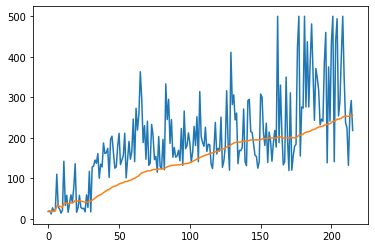

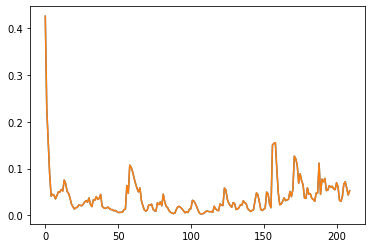

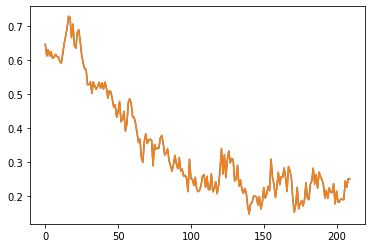

moving average: 318.8
episode #217
-----
I	Tot	V	P	N
0	0.86	0.76	0.10	30
1	0.86	0.72	0.14	169
-----
reward 1.0
-----
I	Tot	V	P	N
0	0.80	0.79	0.00	1
1	0.85	0.70	0.15	228
-----
reward 2.0
-----
I	Tot	V	P	N
0	0.79	0.75	0.05	30
1	0.80	0.69	0.11	397
-----
reward 3.0
-----
I	Tot	V	P	N
0	0.80	0.80	0.00	1
1	0.83	0.68	0.15	228
-----
reward 4.0
-----
I	Tot	V	P	N
0	0.78	0.75	0.03	16
1	0.78	0.67	0.12	411
-----
reward 5.0
-----
I	Tot	V	P	N
0	0.77	0.66	0.10	591
1	0.76	0.76	0.00	19
-----
reward 6.0
-----
I	Tot	V	P	N
0	0.74	0.73	0.01	20
1	0.75	0.66	0.09	770
-----
reward 7.0
-----
I	Tot	V	P	N
0	0.74	0.65	0.08	934
1	0.73	0.73	0.00	35
-----
reward 8.0
-----
I	Tot	V	P	N
0	0.72	0.72	0.01	28
1	0.73	0.65	0.08	1105
-----
reward 9.0
-----
I	Tot	V	P	N
0	0.72	0.64	0.07	1246
1	0.72	0.71	0.01	58
-----
reward 10.0
-----
I	Tot	V	P	N
0	0.71	0.71	0.00	31
1	0.71	0.64	0.07	1414
-----
reward 11.0
-----
I	Tot	V	P	N
0	0.70	0.63	0.07	1499
1	0.70	0.69	0.01	114
-----
reward 12.0
-----
I	Tot	V	P	N
0	0.70	0.70	0.00	51
1	0.70	0.

In [ ]:
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

BUFFER_SIZE = int(1000)   # replay buffer size
BATCH_SIZE = 128          # minibatch size
UPDATE_EVERY = 1

episodes = 250

rewards = []
moving_average = []
v_losses = []
p_losses = []

# the maximum reward of the current game to scale the values
MAX_REWARD = 500

# Create the replay buffer
replay_buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

# Create the Value neural network. 
#The loss is the Mean Squared Error between predicted and actual values.
policy_v = PolicyV()
policy_v.compile(optimizer=keras.optimizers.Adam(), 
                 loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])


# Create the Policy neural network. 
#The loss is the Categorical Crossentropy between the predicted and actual policy according to visit counts.
policy_p = PolicyP()
policy_p.compile(optimizer=keras.optimizers.Adam(), 
                 loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=[tf.keras.metrics.CategoricalCrossentropy()])

'''
Here we are experimenting with our implementation:
- we play a certain number of episodes of the game
- for deciding each move to play at each step, we will apply our AlphaZero algorithm
- we will collect and plot the rewards to check if the AlphaZero is actually working.
- For CartPole-v1, in particular, 500 is the maximum possible reward. 
'''

for e in range(episodes):

    reward_e = 0    
    game = gym.make(GAME_NAME)
    observation = game.reset() 
    done = False
    
    new_game = deepcopy(game)
    mytree = Node(new_game, False, 0, observation, 0)
    
    print('episode #' + str(e+1))
    
    obs = []
    ps = []
    p_obs = []
    
    step = 0
    
    while not done:
        
        step = step + 1
    
        mytree, action, ob, p, p_ob = Policy_Player_MCTS(mytree)
        
        obs.append(ob)
        ps.append(p)
        p_obs.append(p_ob)      
            
        _, reward, done, _ = game.step(action)  
            
        reward_e = reward_e + reward
        
        #game.render()
        
        print('reward ' + str(reward_e))
                
        if done:
            for i in range(len(obs)):
                replay_buffer.add(obs[i], reward_e, p_obs[i], ps[i])
            game.close()
            break
        
    print('reward ' + str(reward_e))
    rewards.append(reward_e)
    moving_average.append(np.mean(rewards[-100:]))
    
    if (e + 1) % UPDATE_EVERY == 0 and len(replay_buffer) > BATCH_SIZE:   
        
        # clear output
        
        for i in range(10):
            clear_output(wait=True) 
        
        # update and train the neural networks
                
        experiences = replay_buffer.sample()
            
        # Each state has as target value the total rewards of the episode
            
        inputs = [[experience.obs] for experience in experiences]
        targets = [[experience.v / MAX_REWARD] for experience in experiences]
            
        inputs = np.array(inputs)
        targets = np.array(targets)
                
        loss_v = policy_v.train_on_batch(inputs, targets)  
                        
        v_losses.append(loss_v)
        
        # Each state has as target policy the policy according to visit counts
            
        inputs = [[experience.p_obs] for experience in experiences]
        targets = [[experience.p] for experience in experiences]
            
        inputs = np.array(inputs)
        targets = np.array(targets)
                
        loss_p = policy_p.train_on_batch(inputs, targets) 
                        
        p_losses.append(loss_p)
        
        # plot rewards, value losses and policy losses
    
        plt.plot(rewards)
        plt.plot(moving_average)
        plt.show()

        plt.plot(v_losses)
        plt.show()

        plt.plot(p_losses)
        plt.show()
        
        print('moving average: ' + str(np.mean(rewards[-20:])))